In [1]:
%load_ext autoreload
%autoreload 2

import os
#os.environ['OMP_NUM_THREADS'] = "6"
#os.environ['OMP_PLACES'] = "{0:6:1}"
#os.environ['KMP_AFFINITY'] = "granularity=fine,compact,1,0"

import sys
import copy
import math
import pickle
import math

sys.path.append("../../")

import numpy as np
import torch
import matplotlib.pyplot as plt
#torch.set_num_threads(6)
import implicitmodules.torch as dm

In [2]:
# First load the deformed peanuts
dataset = pickle.load(open("../../data/peanuts.pickle", 'rb'))

peanuts = [torch.tensor(p[:-1], dtype=torch.get_default_dtype()) for p in dataset[0]]
#peanuts = [p - torch.mean(p, dim=0) for p in peanuts]

template = peanuts[0]
peanuts = peanuts[1:]
print("Number of peanuts:", len(peanuts))

Number of peanuts: 19


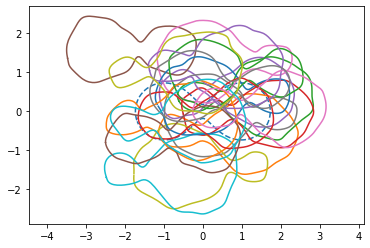

In [3]:
plt.plot(template[:, 0].numpy(), template[:, 1].numpy(), '--')
for p in peanuts:
    plt.plot(p[:, 0].numpy(), p[:, 1].numpy())
plt.axis('equal')
plt.show()

In [4]:
def sigmoid(pos, scale0, scale1, trans0, trans1, lambda0, lambda1):
    C = torch.zeros(pos.shape[0], 2, 2)
    C[:, 0, 0] = scale0*torch.sigmoid(lambda0**2*(pos[:, 0]+trans0))
    C[:, 1, 0] = scale0*torch.sigmoid(lambda0**2*(pos[:, 0]+trans0))
    C[:, 0, 1] = scale1*torch.sigmoid(-lambda1**2*(pos[:, 0]+trans1))
    C[:, 1, 1] = scale1*torch.sigmoid(-lambda1**2*(pos[:, 0]+trans1))
    return C

def myParametricModel(init_manifold, modules, parameters):
    param = parameters[-1]
    scales = param[0]
    trans = param[1]
    lambdas = param[2]
    pos = modules[1].manifold.gd[0].detach().view(-1, 2)
    modules[1]._ImplicitModule1__C = sigmoid(pos, scales[0], scales[1], trans[0], trans[1], lambdas[0], lambdas[1])
    #modules[2].coeff = 100.*math.exp(-0.01*cur_it)

In [5]:
aabb_template = dm.Utilities.AABB.build_from_points(template)
aabb_template.scale(2.)
aabb_total = dm.Utilities.AABB.build_from_points(torch.cat(peanuts))

density = 15
sigma = 1.5/math.sqrt(density)

area = lambda x, **kwargs: dm.Utilities.area_shape(x, shape=template, side=1) | dm.Utilities.area_polyline_outline(x, polyline=template, width=sigma)

pts_implicit1 = dm.Utilities.fill_area_uniform_density(area, aabb_template, density, shape=template, side=1)
print(pts_implicit1.shape)
angles = 0. * math.pi * torch.ones(pts_implicit1.shape[0])
R = torch.stack([dm.Utilities.rot2d(a) for a in angles])

torch.Size([114, 2])


In [ ]:
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
plt.plot(pts_implicit1[:, 0].numpy(), pts_implicit1[:, 1].numpy(), '.')
plt.show()

In [6]:
load_abc = False
if not load_abc:
    abc = torch.zeros(3, 2)
    abc[0] = torch.tensor([1., 1.])
    abc[1] = torch.tensor([-0.5, 0.5])
    abc[2] = 4.*torch.tensor([1., 1.])
else:
    abc = torch.tensor(pickle.load(open("saved_coef.pickle", 'rb')))

print(abc)

C = sigmoid(pts_implicit1, abc[0, 0], abc[0, 1], abc[1, 0], abc[1, 1], abc[2, 0], abc[2, 1])

abc.requires_grad_()

implicit1 = dm.DeformationModules.ImplicitModule1.build_and_fill(2, pts_implicit1.shape[0], C, sigma, 0.001, coeff=0.5, gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))

tensor([[ 1.0000,  1.0000],
        [-0.5000,  0.5000],
        [ 4.0000,  4.0000]])


In [ ]:
%matplotlib qt5

ax = plt.subplot(1, 2, 1)
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
dm.Utilities.plot_C_ellipse(ax, pts_implicit1, C.detach().numpy(), c_index=0, scale=.5)
plt.axis('equal')
ax = plt.subplot(1, 2, 2)
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
dm.Utilities.plot_C_ellipse(ax, pts_implicit1, C.detach().numpy(), c_index=1, scale=.5)
plt.axis('equal')
plt.show()

In [7]:
sigma0 = 0.2
nu0 = 0.01
implicit0 = dm.DeformationModules.ImplicitModule0.build_from_points(2, template.shape[0], sigma0, nu0, coeff=2., gd=template.view(-1).requires_grad_())

In [8]:
my_atlas = dm.Models.Atlas(template, [implicit1, dm.DeformationModules.GlobalTranslation(2)], [dm.Attachment.VarifoldAttachement([0.1, 0.5, 1.2])], len(peanuts), lam=1000., model_precompute_callback=myParametricModel, other_parameters=[abc], optimise_template=False)

In [9]:
shoot_it = 10
shoot_method = 'euler'

In [10]:
cur_it = 0
def post_iteration_callback(model):
    global cur_it
    cur_it = cur_it + 1

fitter = dm.Models.ModelFittingScipy(my_atlas, 1., post_iteration_callback=post_iteration_callback)
bounds = [(None, None)]*fitter.vector_size()
bounds[-4] = (-1., 1.)
bounds[-3] = (-1., 1.)


In [11]:
costs = fitter.fit(peanuts, 400, options={'shoot_it': shoot_it, 'shoot_method': shoot_method, 'bounds': bounds }, log_interval=1)

Initial energy = 452221.719


Iteration: 1 
Total energy = 209021.484375 
Attach cost = 209012.953125 
Deformation cost = 8.526985


Iteration: 2 
Total energy = 168010.125000 
Attach cost = 167995.968750 
Deformation cost = 14.161962


Iteration: 3 
Total energy = 141280.125000 
Attach cost = 141267.031250 
Deformation cost = 13.099352


Iteration: 4 
Total energy = 129982.593750 
Attach cost = 129968.867188 
Deformation cost = 13.723817


Iteration: 5 
Total energy = 125871.429688 
Attach cost = 125857.101562 
Deformation cost = 14.323366


Iteration: 6 
Total energy = 124943.296875 
Attach cost = 124929.664062 
Deformation cost = 13.623471


Iteration: 7 
Total energy = 123662.078125 
Attach cost = 123648.343750 
Deformation cost = 13.731187


Iteration: 8 
Total energy = 123449.453125 
Attach cost = 123435.695312 
Deformation cost = 13.761113


Iteration: 9 
Total energy = 123413.992188 
Attach cost = 123400.343750 
Deformation cost = 13.655465


Iteration: 10 
Total energy = 123366.265625 
Attach cost = 123352.546875 
Deformation cost = 13.694573


Iteration: 11 
Total energy = 123360.765625 
Attach cost = 123347.101562 
Deformation cost = 13.664332


Iteration: 12 
Total energy = 123356.078125 
Attach cost = 123342.453125 
Deformation cost = 13.627341


Iteration: 13 
Total energy = 123354.414062 
Attach cost = 123340.828125 
Deformation cost = 13.601446


Iteration: 14 
Total energy = 123353.203125 
Attach cost = 123339.601562 
Deformation cost = 13.606152


Iteration: 15 
Total energy = 123352.593750 
Attach cost = 123339.000000 
Deformation cost = 13.607472


Iteration: 16 
Total energy = 123352.390625 
Attach cost = 123338.773438 
Deformation cost = 13.607976


Iteration: 17 
Total energy = 123351.750000 
Attach cost = 123338.156250 
Deformation cost = 13.607579


Iteration: 18 
Total energy = 123351.031250 
Attach cost = 123337.421875 
Deformation cost = 13.613813


Iteration: 19 
Total energy = 123349.687500 
Attach cost = 123336.085938 
Deformation cost = 13.612080


Iteration: 20 
Total energy = 123343.406250 
Attach cost = 123329.781250 
Deformation cost = 13.607638


Iteration: 21 
Total energy = 123332.570312 
Attach cost = 123318.968750 
Deformation cost = 13.608774


Iteration: 22 
Total energy = 123303.210938 
Attach cost = 123289.593750 
Deformation cost = 13.611153


Iteration: 23 
Total energy = 123241.328125 
Attach cost = 123227.671875 
Deformation cost = 13.650114


Iteration: 24 
Total energy = 123117.468750 
Attach cost = 123103.757812 
Deformation cost = 13.699139


Iteration: 25 
Total energy = 122660.500000 
Attach cost = 122646.601562 
Deformation cost = 13.891140


Iteration: 26 
Total energy = 120721.398438 
Attach cost = 120705.132812 
Deformation cost = 16.268475


Iteration: 27 
Total energy = 117796.421875 
Attach cost = 117768.328125 
Deformation cost = 28.090994


Iteration: 28 
Total energy = 115185.757812 
Attach cost = 115108.750000 
Deformation cost = 77.017715


Iteration: 29 
Total energy = 110109.382812 
Attach cost = 110021.085938 
Deformation cost = 88.309387


Iteration: 30 
Total energy = 108211.914062 
Attach cost = 108114.320312 
Deformation cost = 97.594452


Iteration: 31 
Total energy = 108148.140625 
Attach cost = 108026.343750 
Deformation cost = 121.798477


Iteration: 32 
Total energy = 108253.554688 
Attach cost = 108131.773438 
Deformation cost = 121.788010
Optimisation process exited with message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Final energy = 108253.5546875
Closure evaluations = 43
Time elapsed = 878.3971083164215


In [12]:
print(torch.tensor(pickle.load(open("saved_coef.pickle", 'rb'))))
print(my_atlas.parameters[-1])

tensor([[ 1.0000,  1.0000],
        [-0.5000,  0.5000],
        [ 4.0000,  4.0000]])
tensor([[ 1.0000,  1.0000],
        [-0.5060,  0.4382],
        [ 3.9980,  3.9885]], requires_grad=True)


In [ ]:
pickle.dump(my_atlas.parameters[-1].detach().tolist(), open("saved_coef.pickle", 'wb'))

In [ ]:
plt.plot(range(len(costs)), costs)
plt.show()

In [ ]:
C_gt = torch.ones(pts_implicit1.shape[0], 2, 1)
C_gt[:, 0 , 0] = 1.*(pts_implicit1[:, 0]+torch.min(pts_implicit1[:, 0]))

In [ ]:
%matplotlib qt5
ax = plt.subplot(1, 2, 1)
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
dm.Utilities.plot_C_ellipse(ax, pts_implicit1, implicit1.C.detach(), c_index=0, alpha=0.3, scale=500., color='blue')
#dm.Utilities.plot_C_arrow(ax, pts_implicit1, C_gt, alpha=0.3, scale=0.3, color='red', mutation_scale=5.)
plt.axis('equal')

ax = plt.subplot(1, 2, 2)
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
dm.Utilities.plot_C_ellipse(ax, pts_implicit1, implicit1.C.detach(), c_index=1, alpha=0.3, scale=0.5,  color='blue')
#dm.Utilities.plot_C_ellipse(ax, pts_implicit1, C_gt, c_index=1, alpha=0.1, scale=0.01, color='C2')
plt.axis('equal')
plt.show()

In [13]:
%matplotlib qt5
it_per_snapshot = 1
snapshots = int(shoot_it/it_per_snapshot)

#ht = my_atlas.compute_template().detach().view(-1, 2)

N = 10

for i in range(N):
    aabb_target = dm.Utilities.AABB.build_from_points(peanuts[i])
    modules = dm.DeformationModules.CompoundModule(my_atlas.models[i].modules)
    modules.manifold.fill(my_atlas.models[i].init_manifold, copy=True)
    h = dm.HamiltonianDynamic.Hamiltonian(modules)
    intermediate_states, _ = dm.HamiltonianDynamic.shoot(h, shoot_it, shoot_method, intermediates=True)

    for j in range(snapshots):
        pos = intermediate_states[it_per_snapshot*j].gd[0].view(-1, 2).numpy()
        pos_impl1 = intermediate_states[it_per_snapshot*j].gd[1][0].view(-1, 2).numpy()
        plt.subplot(N, snapshots + 1, i*snapshots + j + i + 1)
        plt.plot(pos[:, 0], pos[:, 1])
        plt.plot(pos_impl1[:, 0], pos_impl1[:, 1], '.')
        plt.axis("equal")
        plt.axis(aabb_target.get_list())


    plt.subplot(N, snapshots + 1, i*snapshots + snapshots + i + 1)
    plt.plot(peanuts[i].numpy()[:, 0], peanuts[i].numpy()[:, 1])
    plt.axis("equal")
    plt.axis(aabb_target.get_list())